In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
np.warnings.filterwarnings('ignore')
import dask.dataframe as dd
import missingno as msno
from pandasql import sqldf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
import matplotlib.gridspec as gridspec
from sklearn import preprocessing

In [2]:
#Always seed the randomness of this universe
np.random.seed(51)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
%%time
train_metadata_kaggle = dd.read_csv('mydata_train_metadata.csv')
test_metadata_kaggle = dd.read_csv('mydata_test_metadata.csv')
train_metadata_kaggle = train_metadata_kaggle.compute()
test_metadata_kaggle = test_metadata_kaggle.compute()
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 97) (3492890, 96)
CPU times: user 2min 19s, sys: 7.59 s, total: 2min 26s
Wall time: 25.2 s


In [5]:
train_metadata_kaggle.head()

,object_id,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness,flux__length,flux__longest_strike_above_mean,flux__longest_strike_below_mean,flux__mean_abs_change,flux__mean_change,flux_by_flux_ratio_sq__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_below_mean,mjd__mean_abs_change,mjd__mean_change,mjd_diff_det,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,haversine,latlon1,hostgal_photoz_certain,A0_sum_flux,A0_mean_flux,A0_std_detected,A1_mean_detected,A2_sum_detected,A4_mean_detected,A5_std_detected,A5_mean_detected,percent_p2_region_minus_1,A2_min_flux,A5_sum_detected,__flux_percentile_ratio_mid50___5_,__flux_percentile_ratio_mid65___2_,__median_absolute_deviation___2_,__qso_log_chi2_qsonu___0_,__stetson_k___1_,__freq1_signif___2_,__stetson_k___2_,__freq3_amplitude1___1_,__median_absolute_deviation___2_.1,__percent_close_to_median___2_,__freq_varrat___5_,__freq_varrat___4_,__qso_log_chi2_qsonu___3_,__qso_log_chi2_qsonu___1_,__qso_log_chi2_qsonu___5_,__std___4_,__freq_varrat___3_,__amplitude___2_,outlierScore,highEnergy_transitory_1.5_TF,lowEnergy_transitory_1.0_TF,lowEnergy_transitory_1.5_TF
0,615,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835268,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,-327.742307,1761.066406,-14.306331,-5.373326,205.036926,1628.427737,-1.475181,0.128917,22370.594834,2806.374162,-1.255123,0.415580,7780.500807,2805.598113,-1.409885,0.339918,7024.003068,2536.068846,-1.449858,0.293128,3245.366349,2741.539785,-1.548319,0.200096,2704.641265,2893.344217,-1.592820,0.125268,352.0,19.0,29.0,202.114067,1.999688,35.0,4.0,2.631898,2.631898,873.7903,0.0000,0.0000,NaN,0.017,92,0.319006,-1.528827,0.000000,-205.03693,-3.254554,0.3528,0.9653,57,0.9830,0.2854,0.9120,0.362,-682.000,52,5.562230e-26,6.719410e-20,368.12900,6.217890,1.091730,5.49891,1.053490,114.465000,368.12900,0.172414,0.401664,0.129578,9.16612,9.508750,7.344980,289.27700,0.110785,646.9220,0.000,0,0,0
1,713,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,-4.884564,29.506064,-20.730002,-6.040676,190.427851,299.586559,-1.014003,0.260052,57.109047,192.539229,-1.097170,-0.087865,44.477327,191.057528,-1.188472,-0.022678,55.270113,212.522263,-1.142896,-0.167176,50.414646,203.892482,-1.190245,-0.064134,100.473776,143.963093,-0.797047,0.218182,350.0,50.0,73.0,2.935177,-0.050944,199.0,8.0,14.352571,14.352571,846.8017,1.6267,0.2552,45.4063,0.007,88,1.698939,3.258921,2.099614,-190.42786,-2.720398,0.3525,0.2678,15,0.0893,0.0000,0.0000,0.250,-10.070,0,2.119070e-02,8.243180e-02,5.10035,2.187190,1.066100,3.95669,1.088180,0.851103,5.10035,0.178571,0.369518,0.166179,2.79753,3.124810,0.659762,6.34953,0.111883,10.2985,0.875,0,1,1
2,730,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,25.373110,66.469870,29.315018,2.619697,3.461790,4.729538,0.47

In [6]:
%%time
train_metadata_kaggle.drop(['outlierScore','highEnergy_transitory_1.5_TF','lowEnergy_transitory_1.0_TF','lowEnergy_transitory_1.5_TF'],axis=1,inplace=True)
test_metadata_kaggle.drop(['outlierScore','highEnergy_transitory_1.5_TF','lowEnergy_transitory_1.0_TF','lowEnergy_transitory_1.5_TF'],axis=1,inplace=True)

CPU times: user 544 ms, sys: 935 ms, total: 1.48 s
Wall time: 1.47 s


In [7]:
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 93) (3492890, 92)


In [8]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [9]:
%%time
final_dict = {}

loss_list = []
temp = train_metadata_kaggle.copy()
#temp = temp.merge(train_metadata[['object_id',column_]],on = 'object_id',how = 'left')
y = temp['target']
del temp['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

#print('Unique classes : ', classes)

train_id = temp['object_id']
del temp['object_id']
# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
clfs = []
importances = pd.DataFrame()
lgb_params = {
'random_state':51,
'device': 'cpu', 
'objective': 'multiclass', 
'num_class': 14, 
'boosting_type': 'gbdt', 
'n_jobs': -1, 
'max_depth': 7, 
'n_estimators': 1000, 
'subsample_freq': 2, 
'subsample_for_bin': 5000, 
'min_data_per_group': 100, 
'max_cat_to_onehot': 4, 
'cat_l2': 1.0, 
'cat_smooth': 59.5, 
'max_cat_threshold': 32, 
'metric_freq': 10, 
'verbosity': -1, 
'metric': 'multi_logloss', 
'xgboost_dart_mode': False, 
'uniform_drop': False, 
'colsample_bytree': 0.5, 
'drop_rate': 0.173, 
'learning_rate': 0.0267, 
'max_drop': 5, 
'min_child_samples': 10, 
'min_child_weight': 100.0, 
'min_split_gain': 0.1, 
'num_leaves': 7, 
'reg_alpha': 0.1, 
'reg_lambda': 0.00023, 
'skip_drop': 0.44, 
'subsample': 0.75}
oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
    val_x, val_y = temp.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=False,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    loss_oof = multi_weighted_logloss(val_y, oof_preds[val_, :])
    #loss_list.append(loss_oof)
    print(fold_,loss_oof)

    imp_df = pd.DataFrame()
    imp_df['feature'] = temp.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
#final_dict[column_] = loss_list

0 0.6306725280126511
1 0.5988910655279867
2 0.6664656365700714
3 0.6026603016468189
4 0.6125772357651881
MULTI WEIGHTED LOG LOSS : 0.62228 
CPU times: user 10min 21s, sys: 1.66 s, total: 10min 22s
Wall time: 1min 25s


In [10]:
%%time
train_metadata = dd.read_csv('train_myoutput.csv')
test_metadata = dd.read_csv('test_myoutput.csv')
train_metadata = train_metadata.compute()
test_metadata = test_metadata.compute()
print(train_metadata.shape,test_metadata.shape)

(7848, 90) (3492890, 89)
CPU times: user 1min 57s, sys: 6.54 s, total: 2min 3s
Wall time: 23.8 s


In [11]:
train_metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,leavg,lestd,lemed,lemfl,lesfl,lemax,ledsl,lemin,lersl,heavg,hestd,hemed,hemfl,hesfl,hemax,hedsl,hemin,hersl,lmavg,lmstd,lmmed,lmmfl,lmsfl,lmmax,lmdsl,lmmin,lmrsl,hmavg,hmstd,hmmed,hmmfl,hmsfl,hmmax,hmdsl,hmmin,hmrsl,llavg,llstd,llmed,llmfl,llsfl,llmax,lldsl,llmin,llrsl,hlavg,hlstd,hlmed,hlmfl,hlsfl,hlmax,hldsl,hlmin,hlrsl,highEnergy_transitory_1.0_TF,highEnergy_transitory_1.5_TF,lowEnergy_transitory_1.0_TF,lowEnergy_transitory_1.5_TF,outlierScore,hipd,hipr,htpd,htpr,lipd,lipr,ltpd,ltpr,lefrsq,lefrsqxf,lmfrsq,lmfrsqxf,llfrsq,llfrsqxf,hefrsq,hefrsqxf,hmfrsq,hmfrsqxf,hlfrsq,hlfrsqxf
0,615,0.969557,0.673682,0.890941,0.574262,1,0.000000,0.000000,0.000000,1.716561,92,0.367218,0.749418,0.377550,0.264274,0.915871,1.186008,0.431278,0.432572,1.855552,0.464892,0.576553,0.380371,0.062189,0.141927,0.820327,0.342725,1.301038,0.800552,0.423993,0.771304,0.422379,0.264653,0.442064,1.124564,0.911592,0.450530,1.658744,0.946460,0.557092,0.921308,0.046446,0.264155,0.803462,0.360976,1.380625,0.974178,0.558262,0.770807,1.334543,0.237991,0.584895,1.208633,0.451811,0.407419,1.885749,1.175079,0.577139,1.272129,0.070072,0.118565,0.811806,0.277562,1.329751,0.845738,False,False,False,False,0.000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,2.567045,0.367793,2.380843,0.489681,2.002273,1.602228,2.204351,0.300706,1.261095,0.907475,1.744370,1.245251
1,713,0.147044,8.842809,0.620702,0.533204,1,0.679954,0.209284,0.965566,0.838486,88,0.960611,0.213946,1.058979,0.017125,0.792887,0.831106,1.149591,1.138391,1.128085,1.025805,0.082898,1.019587,0.002797,0.167623,0.499451,1.107997,2.314684,0.604746,0.701382,0.244678,0.733772,0.036893,0.404617,0.747282,1.188099,1.098708,0.809151,0.837241,0.124637,0.785390,0.009717,0.149475,0.510584,1.099764,2.335214,0.898123,0.678141,0.173192,0.761128,0.014237,0.532073,0.510462,1.123423,0.919886,0.928880,0.704977,0.066137,0.749123,0.002445,0.137496,0.153697,1.494559,2.139723,1.010275,True,False,True,True,0.875,1.909016,2.0,1.0,1.0,2.0,1.700566,1.591461,1.677849,1.994879,1.111176,1.257270,0.799570,1.812764,0.858760,1.363383,0.936744,1.202222,1.036805,1.554486,0.791749
2,730,0.092819,13.913876,0.473262,0.425706,1,0.094551,0.012875,0.856046,1.925672,42,0.656940,0.072124,0.711667,0.043192,0.844469,0.658834,1.242174,1.232450,1.035636,0.978976,0.091184,1.016489,0.028617,0.105791,0.497219,1.123252,2.230497,0.664530,0.918478,0.145268,0.981610,0.048640,0.394245,0.657440,0.885919,1.187092,1.247504,0.715178,0.123954,0.710529,0.021879,0.264068,0.469126,0.910688,2.222513,1.077681,1.029846,0.324415,1.115434,0.004418,0.509298,0.913485,1.100752,1.106755,0.969224,1.115398,0.244734,1.165928,0.015704,0.127915,0.625662,1.424781,2.506604,0.736385,False,False,False,False,0.000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.256907,0.675534,1.456755,1.168375,1.787233,1.381269,1.326606,0.916505,1.352679,0.916033,1.598755,1.117744
3,745,0.000039,4.585453,0.911661,0.313148,1,0.117582,0.944978,0.867508,0.838486,90,1.021002,0.095485,1.138718,0.003074,0.838895,0.698338,1.381036,1.181234,0.896974,0.950050,0.088108,0.869748,0.018055,0.148716,0.502734,1.160181,2.289767,0.556268,1.114981,0.535460,1.160204,0.018975,0.400172,1.037849,0.830995,1.592998,1.227352,1.091163,0.306529,1.101003,0.010034,0.289854,0.714691,0.990543,3.630944,1.001846,0.661092,0.172586,1.189519,0.023345,0.512444,0.800348,1.075083,1.112832,1.240741,0.780153,0.113672,0.684755,0.027680,0.519170,0.487101,1.466822,2.294358,0.703130,False,False,False,False,0.000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.248631,1.203589,2.135715,1.396319,0.967320,1.509607,1.282409,1.016148,1.701211,1.238302,0.624823,0.380745
4,1124,0.979744,0.224128,0.880178,0.584793,1,0.100946,0.014433,0.859460,2.057815,90,0.761852,0.079376,0.856350,0.047877,0.851406,0.682397,1.489406,1.185845,0.788761,1.239698,0.095741,0.950943,0.036811,0.162019,0.491777,1.146786,2.274372,0.568711,0.650563,0.130556,0.731502,0.043202,0.43132

In [12]:
bool_columns = ['highEnergy_transitory_1.0_TF',
                'highEnergy_transitory_1.5_TF',
               'lowEnergy_transitory_1.0_TF',
               'lowEnergy_transitory_1.5_TF']

In [13]:
train_metadata['highEnergy_transitory_1.0_TF'].head()*1

0    0
1    1
2    0
3    0
4    0
Name: highEnergy_transitory_1.0_TF, dtype: int64

In [14]:
used_columns = [x for x in train_metadata.columns if x not in train_metadata_kaggle.columns]

In [15]:
print(used_columns)

['ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'leavg', 'lestd', 'lemed', 'lemfl', 'lesfl', 'lemax', 'ledsl', 'lemin', 'lersl', 'heavg', 'hestd', 'hemed', 'hemfl', 'hesfl', 'hemax', 'hedsl', 'hemin', 'hersl', 'lmavg', 'lmstd', 'lmmed', 'lmmfl', 'lmsfl', 'lmmax', 'lmdsl', 'lmmin', 'lmrsl', 'hmavg', 'hmstd', 'hmmed', 'hmmfl', 'hmsfl', 'hmmax', 'hmdsl', 'hmmin', 'hmrsl', 'llavg', 'llstd', 'llmed', 'llmfl', 'llsfl', 'llmax', 'lldsl', 'llmin', 'llrsl', 'hlavg', 'hlstd', 'hlmed', 'hlmfl', 'hlsfl', 'hlmax', 'hldsl', 'hlmin', 'hlrsl', 'highEnergy_transitory_1.0_TF', 'highEnergy_transitory_1.5_TF', 'lowEnergy_transitory_1.0_TF', 'lowEnergy_transitory_1.5_TF', 'outlierScore', 'hipd', 'hipr', 'htpd', 'htpr', 'lipd', 'lipr', 'ltpd', 'ltpr', 'lefrsq', 'lefrsqxf', 'lmfrsq', 'lmfrsqxf', 'llfrsq', 'llfrsqxf', 'hefrsq', 'hefrsqxf', 'hmfrsq', 'hmfrsqxf', 'hlfrsq', 'hlfrsqxf']


In [16]:
%%time
#Converting bool to int
for i in bool_columns:
    train_metadata[i] = train_metadata[i] * 1
    test_metadata[i] = test_metadata[i] * 1

CPU times: user 69.2 ms, sys: 43.7 ms, total: 113 ms
Wall time: 112 ms


# Feature Importances

In [17]:
used_from_train_metadata = ['object_id','outlierScore', 'hipd', 'lipd', 'highEnergy_transitory_1.0_TF',
          'highEnergy_transitory_1.5_TF', 'lowEnergy_transitory_1.0_TF', 
          'lowEnergy_transitory_1.5_TF']

In [18]:
"""temp = train_metadata_kaggle.copy()
temp = temp.merge(train_metadata[used_from_train_metadata],on = 'object_id',how = 'left')"""

"temp = train_metadata_kaggle.copy()\ntemp = temp.merge(train_metadata[used_from_train_metadata],on = 'object_id',how = 'left')"

In [19]:
columns_list = ['outlierScore', 'hipd', 'lipd', 'highEnergy_transitory_1.0_TF','highEnergy_transitory_1.5_TF', 'lowEnergy_transitory_1.0_TF', 'lowEnergy_transitory_1.5_TF']

In [ ]:
%%time
final_dict = {}

for column_ in columns_list:
    loss_list = []
    temp = train_metadata_kaggle.copy()
    temp = temp.merge(train_metadata[[x for x in used_from_train_metadata if x != column_ ]],on = 'object_id',how = 'left')

    y = temp['target']
    del temp['target']
    classes = sorted(y.unique())

    # Taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    class_weight = {
        c: 1 for c in classes
    }
    for c in [64, 15]:
        class_weight[c] = 2

    #print('Unique classes : ', classes)

    train_id = temp['object_id']
    del temp['object_id']
    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
    clfs = []
    importances = pd.DataFrame()
    lgb_params = {
    'random_state':51,
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 14, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 7, 
    'n_estimators': 1000, 
    'subsample_freq': 2, 
    'subsample_for_bin': 5000, 
    'min_data_per_group': 100, 
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5, 
    'max_cat_threshold': 32, 
    'metric_freq': 10, 
    'verbosity': -1, 
    'metric': 'multi_logloss', 
    'xgboost_dart_mode': False, 
    'uniform_drop': False, 
    'colsample_bytree': 0.5, 
    'drop_rate': 0.173, 
    'learning_rate': 0.0267, 
    'max_drop': 5, 
    'min_child_samples': 10, 
    'min_child_weight': 100.0, 
    'min_split_gain': 0.1, 
    'num_leaves': 7, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.00023, 
    'skip_drop': 0.44, 
    'subsample': 0.75}
    oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
        val_x, val_y = temp.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=False,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights)
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        loss_oof = multi_weighted_logloss(val_y, oof_preds[val_, :])
        loss_list.append(loss_oof)
        print(column_,fold_,loss_oof)

        imp_df = pd.DataFrame()
        imp_df['feature'] = temp.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)
    print(column_,'MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
    final_dict[column_] = loss_list

In [20]:
%%time
final_dict = {}

loss_list = []
temp = train_metadata_kaggle.copy()
temp = temp.merge(train_metadata[used_from_train_metadata],on = 'object_id',how = 'left')

print(temp.shape)
y = temp['target']
del temp['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

#print('Unique classes : ', classes)

train_id = temp['object_id']
del temp['object_id']
# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)
clfs = []
importances = pd.DataFrame()
lgb_params = {
'random_state':51,
'device': 'cpu', 
'objective': 'multiclass', 
'num_class': 14, 
'boosting_type': 'gbdt', 
'n_jobs': -1, 
'max_depth': 7, 
'n_estimators': 1000, 
'subsample_freq': 2, 
'subsample_for_bin': 5000, 
'min_data_per_group': 100, 
'max_cat_to_onehot': 4, 
'cat_l2': 1.0, 
'cat_smooth': 59.5, 
'max_cat_threshold': 32, 
'metric_freq': 10, 
'verbosity': -1, 
'metric': 'multi_logloss', 
'xgboost_dart_mode': False, 
'uniform_drop': False, 
'colsample_bytree': 0.5, 
'drop_rate': 0.173, 
'learning_rate': 0.0267, 
'max_drop': 5, 
'min_child_samples': 10, 
'min_child_weight': 100.0, 
'min_split_gain': 0.1, 
'num_leaves': 7, 
'reg_alpha': 0.0, 
'reg_lambda': 0.00023, 
'skip_drop': 0.44, 
'subsample': 0.75}
oof_preds = np.zeros((len(temp), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = temp.iloc[trn_], y.iloc[trn_]
    val_x, val_y = temp.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=False,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    loss_oof = multi_weighted_logloss(val_y, oof_preds[val_, :])
    #loss_list.append(loss_oof)
    print(fold_,loss_oof)

    imp_df = pd.DataFrame()
    imp_df['feature'] = temp.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
#final_dict[column_] = loss_list

(7848, 100)
0 0.6289904174615418
1 0.5900237369994543
2 0.6606011056591404
3 0.6061417546722364
4 0.6170530747174007
MULTI WEIGHTED LOG LOSS : 0.62062 
CPU times: user 11min 4s, sys: 1.8 s, total: 11min 5s
Wall time: 1min 31s


In [22]:
%%time
train_metadata_kaggle = train_metadata_kaggle.merge(train_metadata[used_from_train_metadata],on = 'object_id',how = 'left')
test_metadata_kaggle = test_metadata_kaggle.merge(test_metadata[used_from_train_metadata],on = 'object_id',how = 'left')

CPU times: user 2.7 s, sys: 2.71 s, total: 5.41 s
Wall time: 5.4 s


In [23]:
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 100) (3492890, 99)


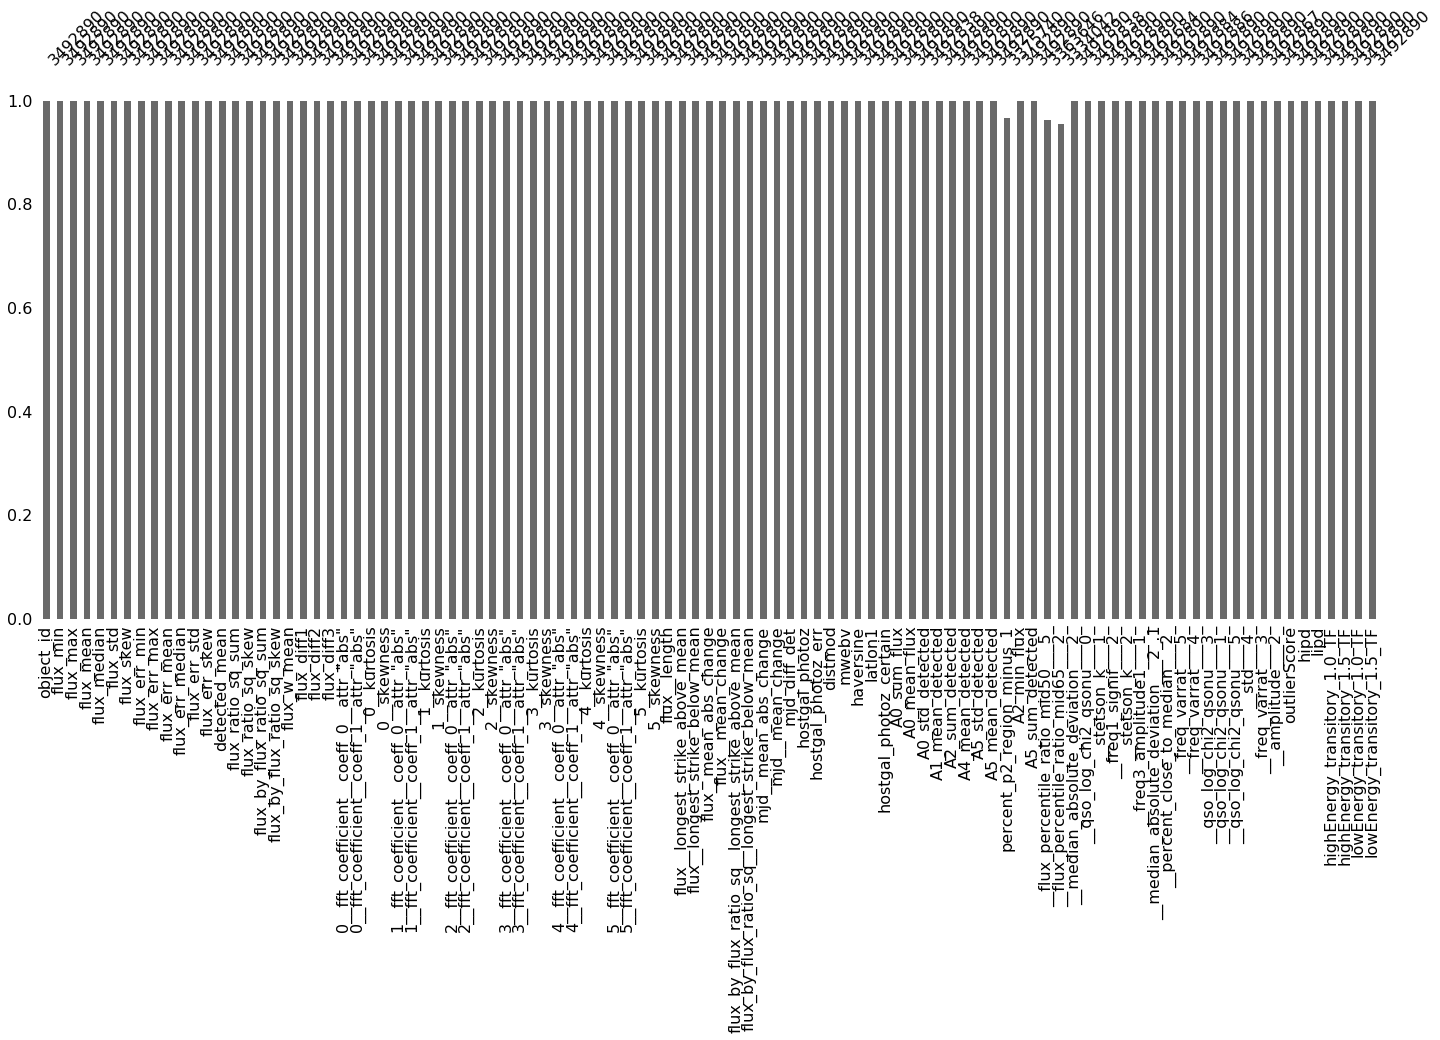

In [24]:
msno.bar(test_metadata_kaggle)

In [25]:
%%time
train_metadata_kaggle.to_csv('mydata_train_metadata.csv',index=False)
test_metadata_kaggle.to_csv('mydata_test_metadata.csv',index=False)

CPU times: user 6min 56s, sys: 5.57 s, total: 7min 1s
Wall time: 7min 2s
